In [1]:
import numpy as np
import pandas as pd

from scipy import linalg
from scipy import sparse
from scipy.sparse.linalg import svds
import ot


from numpy.linalg import matrix_rank
import itertools
import copy
import time as time
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet
from scipy.spatial. distance import pdist
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import hdbscan

from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, fowlkes_mallows_score
from scipy.stats import rankdata,kendalltau,sem

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE
from random import choices

from matplotlib.lines import Line2D

from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package wordnet to /home/ag16115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import random 
random.seed(1)

# Functions 

## General

In [3]:
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def reverse_dict(dic):
    for r in dic.keys():
        if not isinstance(dic[r], list):
            dic[r] = [dic[r]]
    inverse = { v: k for k, l in dic.items() for v in l }
    return inverse

def pc_scores(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    return Y

def embed_cov(X, r):
    if r == X.shape[0]:
        U, s, Vh = np.linalg.svd(X, full_matrices=True)
    else:
        U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    ## need to take square root as these are eigenvalues
    Y = U @ np.diag(np.sqrt(s)) 
    return Y

def find_rows_to_merge(F):
    f = copy.deepcopy(F)
    np.fill_diagonal(f, -np.inf)
    i,j = np.unravel_index(f.argmax(), f.shape)
    return [i,j]   

def inner_products(X):
    return X.dot(X.T)

def wasserstein_dim_select(Y, split = 0.5, rmin = 1, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    if sparse.issparse(Y):
        Y = Y.todense()
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rtry-1)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in tqdm(range(rmin,rtry+1)):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

## Text functions

In [4]:
def del_email_address(text):
    e = '\S*@\S*\s?'
    pattern = re.compile(e)
    return pattern.sub('', text) 

def clean_text(text):
    return " ".join([ Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split() if word not in stopword])  

## IP HC

In [5]:
# def ip_metric(X,Y):
#     return  np.exp(-np.sum(X * Y))

# def ip_affinity(X):
#     return pairwise_distances(X, metric = ip_metric)

def ip_metric(X,Y):
    return  np.sum(X * Y)

def ip_affinity(X):
    ips = pairwise_distances(X, metric = ip_metric)
    return np.max(ips) - ips

In [6]:
def clusters_to_labels(clusters):
    d = defaultdict(list)
    for index, sublist in enumerate(clusters):
        for item in sublist:
            d[item].append(index)
    labels = flatten_list([d[c] for c in range(len(d.keys()))])
    return labels

## Ranking

In [7]:
def find_ancestors(model, target):
    n_samples = len(model.labels_)
    global ances
    for ind, merge in enumerate(model.children_):
        if target in merge:
            if n_samples+ind in ances:
                return [target]+ ances[n_samples+ind]
            ances[n_samples+ind] = find_ancestors(model,n_samples+ind)
            return [target]+ances[n_samples+ind]
    return [ind+n_samples]

def find_descendents(model,node):
    n_samples = len(model.labels_)
    global desc
    if node in desc:
        return desc[node]
    if node < n_samples:
        return [node]
    pair = model.children_[node-n_samples]
    desc[node] = find_descendents(model,pair[0])+find_descendents(model,pair[1])
    return desc[node]

def get_ranking(model, target):
    rank = np.zeros(len(model.labels_))
    to_root = [find_descendents(model, cl) for cl in find_ancestors(model, target)]
    to_rank = [list(set(to_root[i+1]) - set(to_root[i])) for i in range(len(to_root)-1)]
    for i in range(1,len(to_rank)+1):
        rank[to_rank[i-1]] = i
    return rank

In [8]:
def find_ancestors_v1(children,n, target):
    n_samples = n
    global ances
    for ind, merge in enumerate(children):
        if target in merge:
            if n_samples+ind in ances:
                return [target]+ ances[n_samples+ind]
            ances[n_samples+ind] = find_ancestors_v1(children,n,n_samples+ind)
            return [target]+ances[n_samples+ind]
    return [ind+n_samples]

def find_descendents_v1(children,n ,node):
    n_samples = n
    global desc
    if node in desc:
        return desc[node]
    if node < n_samples:
        return [node]
    pair = children[node-n_samples]
    desc[node] = find_descendents_v1(children,n,pair[0])+find_ancestors_v1(children,n,pair[1])
    return desc[node]

def get_ranking_v1(children,n, target):
    rank = np.zeros(n)
    to_root = [find_descendents_v1(children,n, cl) for cl in find_ancestors_v1(children,n, target)]
    to_rank = [list(set(to_root[i+1]) - set(to_root[i])) for i in range(len(to_root)-1)]
    for i in range(1,len(to_rank)+1):
        rank[to_rank[i-1]] = i
    return rank

## Dendrogram

In [9]:
def plot_dendrogram(model, rescale = False, size = (10,10), **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    if rescale == True:
        d_max = np.max(model.distances_)
        d_min = np.min(model.distances_)
        distances = (model.distances_ - d_min) / (d_max - d_min)
    else:
        distances = model.distances_

    linkage_matrix = np.column_stack(
        [model.children_, distances, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize = size)
    dendrogram(linkage_matrix, **kwargs)

In [10]:
def linkage_matrix(model, rescale = False):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    if rescale == True:
        d_max = np.max(model.distances_)
        d_min = np.min(model.distances_)
        distances = (model.distances_ - d_min) / (d_max - d_min)
    else:
        distances = model.distances_

    linkage_matrix = np.column_stack(
        [model.children_, distances, counts]
    ).astype(float)

    return linkage_matrix

# Process data

In [11]:
## load and process data
newsgroups = fetch_20newsgroups() # remove=('headers', 'footers', 'quotes')
# # pprint(list(newsgroups.target_names))

## create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', 1, expand=True)

# ## use random sample of data 
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

n = len(df)

## list of common words to delete
stopword = set(nltk.corpus.stopwords.words("english"))
stopword.update(['subject'])

## gets rid of email addresses  in data
df["data_str"] = df.data.apply(lambda row: del_email_address(row))
# gets rid of stopwords, symbols, makes lower case and base words
df["data_str"] = df.data_str.apply(lambda row: clean_text(row))

## vectorize data
vectorizer = TfidfVectorizer(min_df = 5, max_df = n-1000)
Y = vectorizer.fit_transform(df.data_str)

# Data load

In [12]:
(n,p) = Y.shape
print(n,p)

5000 12818


In [13]:
## dimension selection
# rmin = 10
# rmax = 75
# ws = wasserstein_dim_select(Y,rmin = rmin, rmax = rmax)
# dim = rmin + np.argmin(ws)
# print(f'Dimension selected: {np.argmin(ws) + rmin}')

In [14]:
dim = 34

In [15]:
zeta = p**-.5 * pc_scores(Y, dim)
zeta = np.array(zeta)

In [16]:
zeta_df = pd.DataFrame(zeta[:,:2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)

In [17]:
labels = df['target']

In [18]:
# colours - topics from the same theme have different shades of the same colour

target_colour = {'alt.atheism' : 'goldenrod',
 'comp.graphics' : 'steelblue',
 'comp.os.ms-windows.misc': 'skyblue',
 'comp.sys.ibm.pc.hardware' : 'lightblue',
 'comp.sys.mac.hardware' : 'powderblue',
 'comp.windows.x' : 'deepskyblue',
 'misc.forsale' : 'maroon',
 'rec.autos' : 'limegreen',
 'rec.motorcycles' : 'green',
 'rec.sport.baseball' : 'yellowgreen',
 'rec.sport.hockey' : 'olivedrab',
 'sci.crypt' : 'pink',
 'sci.electronics' : 'plum',
 'sci.med' : 'orchid',
 'sci.space' : 'palevioletred',
 'soc.religion.christian' : 'darkgoldenrod', 
 'talk.politics.guns' : 'coral',
 'talk.politics.mideast' : 'tomato',
 'talk.politics.misc' : 'darksalmon',
 'talk.religion.misc' : 'gold'}

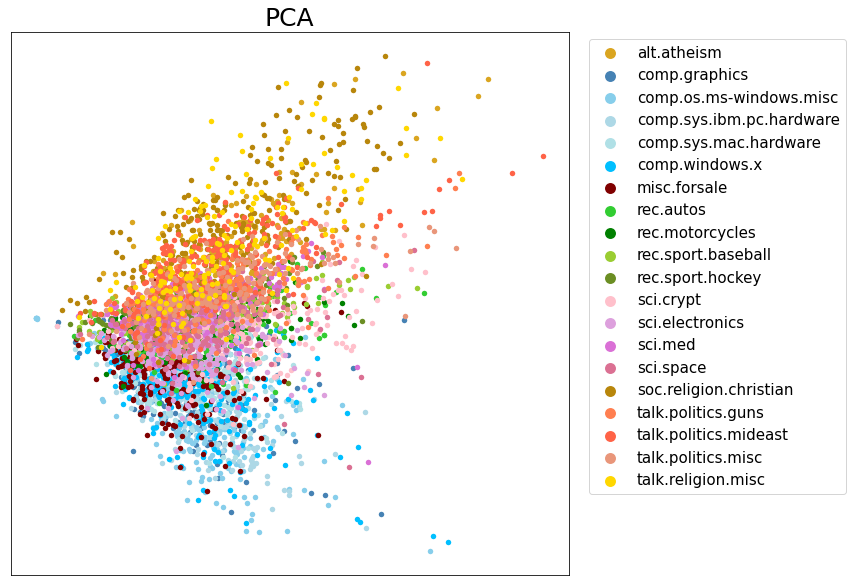

In [19]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax.scatter(t_df[0],t_df[1], marker = 'o',edgecolor='black', linewidth=0,s = 30,label = t,c= target_colour[t]);
ax.set_title(f'PCA',fontsize=25)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.legend(loc='upper right', bbox_to_anchor=(1.51, 1) ,prop={'size': 15}, markerscale=2)
plt.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig(f"newsgroup.pdf", bbox_inches='tight')

In [21]:
# stop

# Clustering

## Rankings

the following labels are taken from: http://qwone.com/~jason/20Newsgroups/

In [20]:
t_true_ranking = np.array([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1],
                            [2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                            [2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                            [3, 2, 2, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [3, 2, 2, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                            [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                            [3, 3, 3, 3, 3, 3, 3, 0, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [3, 3, 3, 3, 3, 3, 3, 1, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 2],
                            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2],
                            [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2],
                            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0]])

xs, ys = np.meshgrid(labels,labels)
true_ranking = t_true_ranking[xs,ys]

## Clustering topic centroids

In [21]:
## to look at dendrogram of topics
idxs = [np.where(np.array(df['target']) == t)[0] for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx,:],axis = 0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx,:],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

### Dendrograms

In [22]:
ip_t_clust = AgglomerativeClustering(affinity = ip_affinity, linkage = 'average',distance_threshold=0, n_clusters=None)
ip_t_clust.fit(t_zeta);

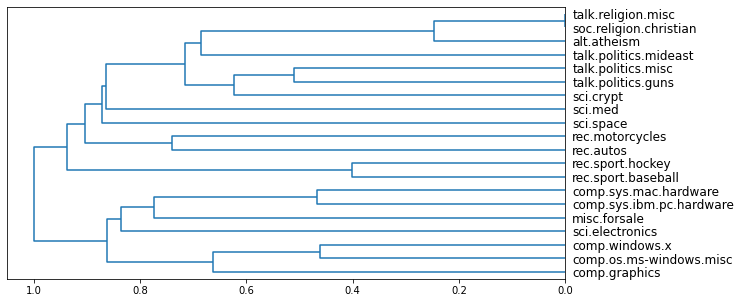

In [23]:
plot_dendrogram(ip_t_clust, rescale = True, labels = list(newsgroups["target_names"]), size = (10,5), orientation='left',truncate_mode="level",color_threshold = 0)

In [24]:
a_t_clust = AgglomerativeClustering(linkage = 'average',distance_threshold=0, n_clusters=None)
a_t_clust.fit(t_zeta);

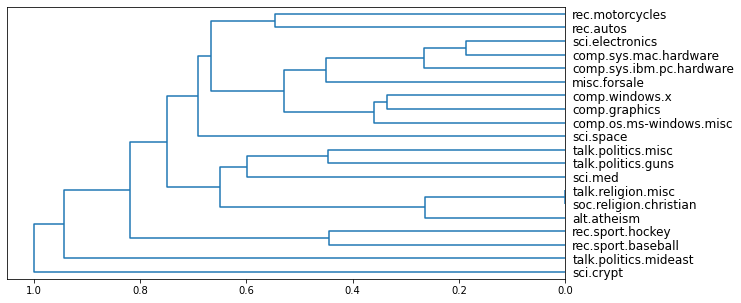

In [25]:
plot_dendrogram(a_t_clust, rescale = True, labels = list(newsgroups["target_names"]), size = (10,5), orientation='left',truncate_mode="level",color_threshold = 0)

## Clustering individual documents

In [28]:
Y = np.asarray(Y.todense())

In [29]:
method_comparison_df = pd.DataFrame()

## on zeta 

In [30]:
%%time
ip_clust = AgglomerativeClustering(affinity = ip_affinity, linkage = 'average',distance_threshold=0, n_clusters=None)
ip_clust.fit(zeta);

CPU times: user 1min 9s, sys: 362 ms, total: 1min 9s
Wall time: 1min 9s


AgglomerativeClustering(affinity=<function ip_affinity at 0x7fe332e02af0>,
                        distance_threshold=0, linkage='average',
                        n_clusters=None)

In [31]:
%%time
ances = {}; desc = {}
ip_ranking = np.array([get_ranking(ip_clust,t) for t in range(n)])

ip_kt_z = [kendalltau(ip_ranking[i], true_ranking[i]).correlation for i in range(ip_ranking.shape[0])]
np.mean(ip_kt_z)

CPU times: user 5min 53s, sys: 543 ms, total: 5min 54s
Wall time: 5min 54s


0.24167756071632676

In [32]:
%%time
ward = AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters = None)
ward.fit(zeta)

CPU times: user 1.22 s, sys: 40.6 ms, total: 1.26 s
Wall time: 1.25 s


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [33]:
%%time
ances = {}; desc = {}
w_ranking = np.array([get_ranking(ward,t) for t in range(n)])

w_kt_z = [kendalltau(w_ranking[i], true_ranking[i]).correlation for i in range(w_ranking.shape[0])]
np.mean(w_kt_z)

CPU times: user 1min 38s, sys: 212 ms, total: 1min 38s
Wall time: 1min 38s


0.1931741407781692

In [34]:
%%time
average = AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters = None)
average.fit(zeta)

CPU times: user 1.31 s, sys: 41.1 ms, total: 1.35 s
Wall time: 1.35 s


AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

In [35]:
%%time
ances = {}; desc  = {}
# idx = choices(range(n), k=500)
a_ranking = np.array([get_ranking(average,t) for t in range(n)])

a_kt_z = [kendalltau(a_ranking[i], true_ranking[i]).correlation for i in range(a_ranking.shape[0])]
np.mean(a_kt_z)

CPU times: user 2min 44s, sys: 583 ms, total: 2min 45s
Wall time: 2min 45s


0.03825892368433082

In [36]:
%%time
cosine = AgglomerativeClustering(affinity = 'cosine', linkage = 'average', distance_threshold=0, n_clusters = None)
cosine.fit(zeta)

CPU times: user 1.11 s, sys: 59.4 ms, total: 1.17 s
Wall time: 1.17 s


AgglomerativeClustering(affinity='cosine', distance_threshold=0,
                        linkage='average', n_clusters=None)

In [37]:
%%time
ances = {}; desc  = {}
# idx = choices(range(n), k=500)
cs_ranking = np.array([get_ranking(cosine,t) for t in range(n)])

cs_kt_z = [kendalltau(cs_ranking[i], true_ranking[i]).correlation for i in range(cs_ranking.shape[0])]
np.mean(cs_kt_z)

CPU times: user 1min 32s, sys: 98.8 ms, total: 1min 32s
Wall time: 1min 32s


0.180776534619209

## on Y 

In [38]:
%%time
ip_clust = AgglomerativeClustering(affinity = ip_affinity, linkage = 'average',distance_threshold=0, n_clusters=None)
ip_clust.fit(Y);

CPU times: user 4min 34s, sys: 1.02 s, total: 4min 35s
Wall time: 4min 36s


AgglomerativeClustering(affinity=<function ip_affinity at 0x7fe332e02af0>,
                        distance_threshold=0, linkage='average',
                        n_clusters=None)

In [39]:
%%time
ances = {}; desc = {}
ip_ranking = np.array([get_ranking(ip_clust,t) for t in range(n)])

ip_kt_y = [kendalltau(ip_ranking[i], true_ranking[i]).correlation for i in range(ip_ranking.shape[0])]
np.mean(ip_kt_y)

CPU times: user 1min 45s, sys: 96.8 ms, total: 1min 45s
Wall time: 1min 45s


0.2563513320510575

In [ ]:
%%time
ward = AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters = None)
ward.fit(Y)

In [ ]:
%%time
ances = {}; desc = {}
w_ranking = np.array([get_ranking(ward,t) for t in range(n)])

w_kt_y = [kendalltau(w_ranking[i], true_ranking[i]).correlation for i in range(w_ranking.shape[0])]
np.mean(w_kt_y)

In [ ]:
%%time
average = AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters = None)
average.fit(Y)

In [ ]:
%%time
ances = {}; desc  = {}
a_ranking = np.array([get_ranking(average,t) for t in range(n)])

a_kt_y = [kendalltau(a_ranking[i], true_ranking[i]).correlation for i in range(a_ranking.shape[0])]
np.mean(a_kt_y)

In [ ]:
%%time
cosine = AgglomerativeClustering(affinity = 'cosine', linkage = 'average', distance_threshold=0, n_clusters = None)
cosine.fit(Y)

In [ ]:
%%time
ances = {}; desc  = {}
cs_ranking = np.array([get_ranking(cosine,t) for t in range(n)])

cs_kt_y = [kendalltau(cs_ranking[i], true_ranking[i]).correlation for i in range(cs_ranking.shape[0])]
np.mean(cs_kt_y)

In [ ]:
method_comparison_df = pd.DataFrame()
method_comparison_df['ip_z'] = [np.mean(ip_kt_z),sem(ip_kt_z)]
method_comparison_df['ip_y'] = [np.mean(ip_kt_y),sem(ip_kt_y)]

method_comparison_df['w_z'] = [np.mean(w_kt_z),sem(w_kt_z)]
method_comparison_df['w_y'] = [np.mean(w_kt_y),sem(w_kt_y)]

method_comparison_df['a_z'] = [np.mean(a_kt_z),sem(a_kt_z)]
method_comparison_df['a_y'] = [np.mean(a_kt_y),sem(a_kt_y)]

method_comparison_df['cs_z'] = [np.mean(cs_kt_z),sem(cs_kt_z)]
method_comparison_df['cs_y'] = [np.mean(cs_kt_y),sem(cs_kt_y)]

method_comparison_df.to_csv('method_comparison.csv', index=False)


### hdbscan

In [ ]:
import sys
sys.getrecursionlimit()
sys.setrecursionlimit(10000)

In [ ]:
hdbscan_ = hdbscan.HDBSCAN(min_cluster_size=2)
hdbscan_.fit(zeta)

hdbscan_.single_linkage_tree_;
hdbscan_.children_ = np.array(hdbscan_.single_linkage_tree_.to_pandas()[['left_child','right_child']], dtype=int)

In [ ]:
%%time
ances = {}; desc = {}
hdbscan_ranking = np.array([get_ranking(hdbscan_,t) for t in range(n)]) # range(n)

hdbscan_kt_z = [kendalltau(hdbscan_ranking[i], true_ranking[i]).correlation for i in range(hdbscan_ranking.shape[0])]
np.mean(hdbscan_kt_z)

In [ ]:
hdbscan_ = hdbscan.HDBSCAN(min_cluster_size=2)
hdbscan_.fit(Y)

hdbscan_.single_linkage_tree_;
hdbscan_.children_ = np.array(hdbscan_.single_linkage_tree_.to_pandas()[['left_child','right_child']], dtype=int)

In [ ]:
%%time
ances = {}; desc = {}
hdbscan_ranking = np.array([get_ranking(hdbscan_,t) for t in range(n)]) # range(n)

hdbscan_kt_y = [kendalltau(hdbscan_ranking[i], true_ranking[i]).correlation for i in range(hdbscan_ranking.shape[0])]
np.mean(hdbscan_kt_y)

In [ ]:
method_comparison_df['hdbscan_z'] = [np.mean(hdbscan_kt_z),sem(hdbscan_kt_z)]
method_comparison_df['hdbscan_y'] = [np.mean(hdbscan_kt_y),sem(hdbscan_kt_y)]

In [ ]:
method_comparison_df.to_csv('method_comparison.csv', index=False)

## Appendix method comparison 

In [ ]:
linkage = ['complete','single']
metric = ['euclidean', 'cosine']
combs = list(itertools.product(linkage, metric))

In [ ]:
method_comparison_df_v2 = pd.DataFrame(columns = ['linkage','metric',
                                                  'zeta_mean','zeta_se','Y_mean','Y_se'])

In [ ]:
for i in range(len(combs)):
    print(combs[i])
    
    on_zeta = AgglomerativeClustering(affinity = combs[i][1], linkage = combs[i][0],distance_threshold=0, n_clusters=None)
    on_zeta.fit(zeta);
    ances = {}; desc = {}
    on_zeta_ranking = np.array([get_ranking(on_zeta,t) for t in range(n)])
    kt_z = [kendalltau(on_zeta_ranking[i], true_ranking[i]).correlation for i in range(on_zeta_ranking.shape[0])]
    
    on_Y = AgglomerativeClustering(affinity = combs[i][1], linkage = combs[i][0],distance_threshold=0, n_clusters=None)
    on_Y.fit(Y);
    ances = {}; desc = {}
    on_Y_ranking = np.array([get_ranking(on_Y,t) for t in range(n)])
    kt_Y = [kendalltau(on_Y_ranking[i], true_ranking[i]).correlation for i in range(on_Y_ranking.shape[0])]
    
    
    new_row = {'linkage': combs[i][0],'metric':combs[i][1],
               'zeta_mean': np.mean(kt_z),'zeta_se': sem(kt_z),
               'Y_mean': np.mean(kt_Y),'Y_se': sem(kt_Y)}
    method_comparison_df_v2 = pd.concat([method_comparison_df_v2,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

In [ ]:
method_comparison_df_v2.to_csv('method_comparison_v2.csv', index=False)

# Comparing distance metrics

Compare distances between points within the same cluster and points in other clusters - to see which methods of clustering are likely to be useful. 

In [ ]:
# ip_F = inner_products(zeta)
# y_ip_F = inner_products(Y)
# D = pairwise_distances(zeta)
# y_D = pairwise_distances(Y)

In [ ]:
# ip_df = pd.DataFrame(columns=['Target1', 'Target2', 'Mean'])
# ed_df = pd.DataFrame(columns=['Target1', 'Target2', 'Mean'])
# y_ip_df = pd.DataFrame(columns=['Target1', 'Target2', 'Mean'])
# y_ed_df = pd.DataFrame(columns=['Target1', 'Target2', 'Mean'])
# i = 0
# for t1 in tqdm(list(set(df["target"]))):
#     idx1 = np.where(np.array(df['target']) == t1)[0]
#     for t2 in list(set(df["target"])):
#         if t2 == t1:
#             same_label = list(itertools.combinations(idx1,2))
#             F1 = [ip_F[i] for i in same_label]
#             F3 = [y_ip_F[i] for i in same_label]
#             D1 = [D[i] for i in same_label]
#             D2 = [y_D[i] for i in same_label]
#             ip_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t1]['target_names'].iloc[0]] + [np.mean(F1)]
#             ed_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t1]['target_names'].iloc[0]] + [np.mean(D1)]
#             y_ip_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t1]['target_names'].iloc[0]] + [np.mean(F3)]
#             y_ed_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t1]['target_names'].iloc[0]] + [np.mean(D2)]
#             i += 1
#         else:
#             idx2 = np.where(np.array(df['target']) == t2)[0]
#             diff_label = list(itertools.product(idx1, idx2))
#             F1 = [ip_F[i] for i in diff_label]
#             F3 = [y_ip_F[i] for i in diff_label]
#             D1 = [D[i] for i in diff_label]
#             D2 = [y_D[i] for i in diff_label]
#             ip_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t2]['target_names'].iloc[0]] + [np.mean(F1)]
#             ed_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t2]['target_names'].iloc[0]] + [np.mean(D1)]
#             y_ip_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t2]['target_names'].iloc[0]] + [np.mean(F3)]
#             y_ed_df.loc[i] = [df[df['target'] == t1]['target_names'].iloc[0]] + [df[df['target'] == t2]['target_names'].iloc[0]] + [np.mean(D2)]
#             i += 1

In [ ]:
# ip_df.to_csv('ip_df.csv', index=False)
# ed_df.to_csv('ed_df.csv', index=False)
# y_ip_df.to_csv('y_ip_df.csv', index=False)
# y_ed_df.to_csv('y_ed_df.csv', index=False)

In [26]:
## loaded as above takes a while to run 
ip_df = pd.read_csv('ip_df.csv')
ed_df = pd.read_csv('ed_df.csv')
y_ip_df = pd.read_csv('y_ip_df.csv')
y_ed_df = pd.read_csv('y_ed_df.csv')

In [27]:
ordered_cats = ['comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
        'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'alt.atheism','soc.religion.christian','talk.religion.misc']

In [28]:
marker_dict = {'alt.atheism' : 'o',
                'talk.religion.misc': 'o',
                'soc.religion.christian': 'o',
                
                 'comp.graphics' : 's',
                 'comp.os.ms-windows.misc' : 's',
                 'comp.windows.x' : 's',
                 'comp.sys.ibm.pc.hardware' : 's',
                 'comp.sys.mac.hardware' : 's',
                
                 'misc.forsale' : '^',
                
                 'rec.autos' : 'd',
                 'rec.motorcycles' : 'd',
                 'rec.sport.baseball' : 'd',
                 'rec.sport.hockey' : 'd',
                
                 'sci.crypt' : 'X',
                 'sci.electronics' : 'X',
                 'sci.med' : 'X',
                 'sci.space' : 'X',

                 'talk.politics.guns' : '*',
                 'talk.politics.mideast' : '*',
                 'talk.politics.misc' : '*',
               }

In [29]:
ip_df['Target1'] = pd.Categorical(ip_df.Target1, categories=ordered_cats, ordered=True)
ip_df = ip_df.sort_values('Target1')

ed_df['Target1'] = pd.Categorical(ed_df.Target1, categories=ordered_cats, ordered=True)
ed_df = ed_df.sort_values('Target1')

y_ip_df['Target1'] = pd.Categorical(y_ip_df.Target1, categories=ordered_cats, ordered=True)
y_ip_df = y_ip_df.sort_values('Target1')

y_ed_df['Target1'] = pd.Categorical(y_ed_df.Target1, categories=ordered_cats, ordered=True)
y_ed_df = y_ed_df.sort_values('Target1')

In [30]:
ip_df['colour'] = [target_colour[c] for c in ip_df['Target2']]
ip_df['marker'] = [marker_dict[c] for c in ip_df['Target2']]

ed_df['colour'] = [target_colour[c] for c in ed_df['Target2']]
ed_df['marker'] = [marker_dict[c] for c in ed_df['Target2']]

In [31]:
reduce_ip_df = pd.DataFrame()
reduce_ed_df = pd.DataFrame()

N = 5

for c in ordered_cats:
    reduce_ip_df = pd.concat([reduce_ip_df, ip_df[ip_df['Target1'] == c].sort_values(by='Mean', ascending=False)[:N]], ignore_index=True)
    reduce_ed_df = pd.concat([reduce_ed_df, ed_df[ed_df['Target1'] == c].sort_values(by='Mean', ascending=True)[:N]], ignore_index=True)

In [32]:
# colours - topics from the same theme have different shades of the same colour
target_colour = {'alt.atheism' : 'gold',
 'comp.graphics' : 'steelblue',
 'comp.os.ms-windows.misc': 'steelblue',
 'comp.sys.ibm.pc.hardware' : 'powderblue',
 'comp.sys.mac.hardware' : 'powderblue',
 'comp.windows.x' : 'steelblue',
 'misc.forsale' : 'maroon',
 'rec.autos' : 'green',
 'rec.motorcycles' : 'green',
 'rec.sport.baseball' : 'yellowgreen',
 'rec.sport.hockey' : 'yellowgreen',
 'sci.crypt' : 'orchid',
 'sci.electronics' : 'orchid',
 'sci.med' : 'orchid',
 'sci.space' : 'orchid',
 'soc.religion.christian' : 'gold', 
 'talk.politics.guns' : 'tomato',
 'talk.politics.mideast' : 'tomato',
 'talk.politics.misc' : 'tomato',
 'talk.religion.misc' : 'gold'}

In [33]:
ip_t_clust_Z = linkage_matrix(ip_t_clust,rescale = True)
a_t_clust_Z = linkage_matrix(a_t_clust,rescale = True)

topic = 'comp.windows.x' 
ip_topic_df = ip_df[ip_df['Target1'] == topic]
ip_topic_df = ip_topic_df[ip_topic_df['Target2'] != topic]
ip_topic_df = ip_topic_df.sort_values(by='Mean', ascending=False)

ed_topic_df = ed_df[ed_df['Target1'] == topic]
ed_topic_df = ed_topic_df[ed_topic_df['Target2'] != topic]
ed_topic_df = ed_topic_df.sort_values(by='Mean', ascending=True)

In [34]:
den_labels = ['atheism',
 'graphics',
 'windows.misc',
 'pc.hardware',
 'mac.hardware',
 'windows.x',
 'forsale',
 'autos',
 'motorcycles',
 'baseball',
 'hockey',
 'crypt',
 'electronics',
 'med',
 'space',
 'christian',
 'guns',
 'mideast',
 'politics.misc',
 'religion.misc']

In [35]:
marker_size = 18

legend_elements = [Line2D([0], [0], marker='s', color='w', label='comp',markeredgecolor='black', linewidth=1,
                          markerfacecolor='steelblue', markersize=marker_size),
                  Line2D([0], [0], marker='s', color='w', label='comp.sys',markeredgecolor='black', linewidth=1,
                          markerfacecolor='powderblue', markersize=marker_size),
                   
                  Line2D([0], [0], marker='^', color='w', label='misc.forsale',markeredgecolor='black', linewidth=1,
                          markerfacecolor='maroon', markersize=marker_size),
                   
                  Line2D([0], [0], marker='d', color='w', label='rec',markeredgecolor='black', linewidth=1,
                          markerfacecolor='green', markersize=marker_size),
                  Line2D([0], [0], marker='d', color='w', label='rec.sport',markeredgecolor='black', linewidth=1,
                          markerfacecolor='yellowgreen', markersize=marker_size),
                  Line2D([0], [0], marker='o', color='w', label=r'religion', markeredgecolor='black', linewidth=1,
                          markerfacecolor='gold', markersize=marker_size),
                   
                  Line2D([0], [0], marker='X', color='w', label='sci',markeredgecolor='black', linewidth=1,
                          markerfacecolor='orchid', markersize=marker_size),
                   
                  Line2D([0], [0], marker='*', color='w', label='talk.politics',markeredgecolor='black', linewidth=1,
                          markerfacecolor='tomato', markersize=marker_size)
]

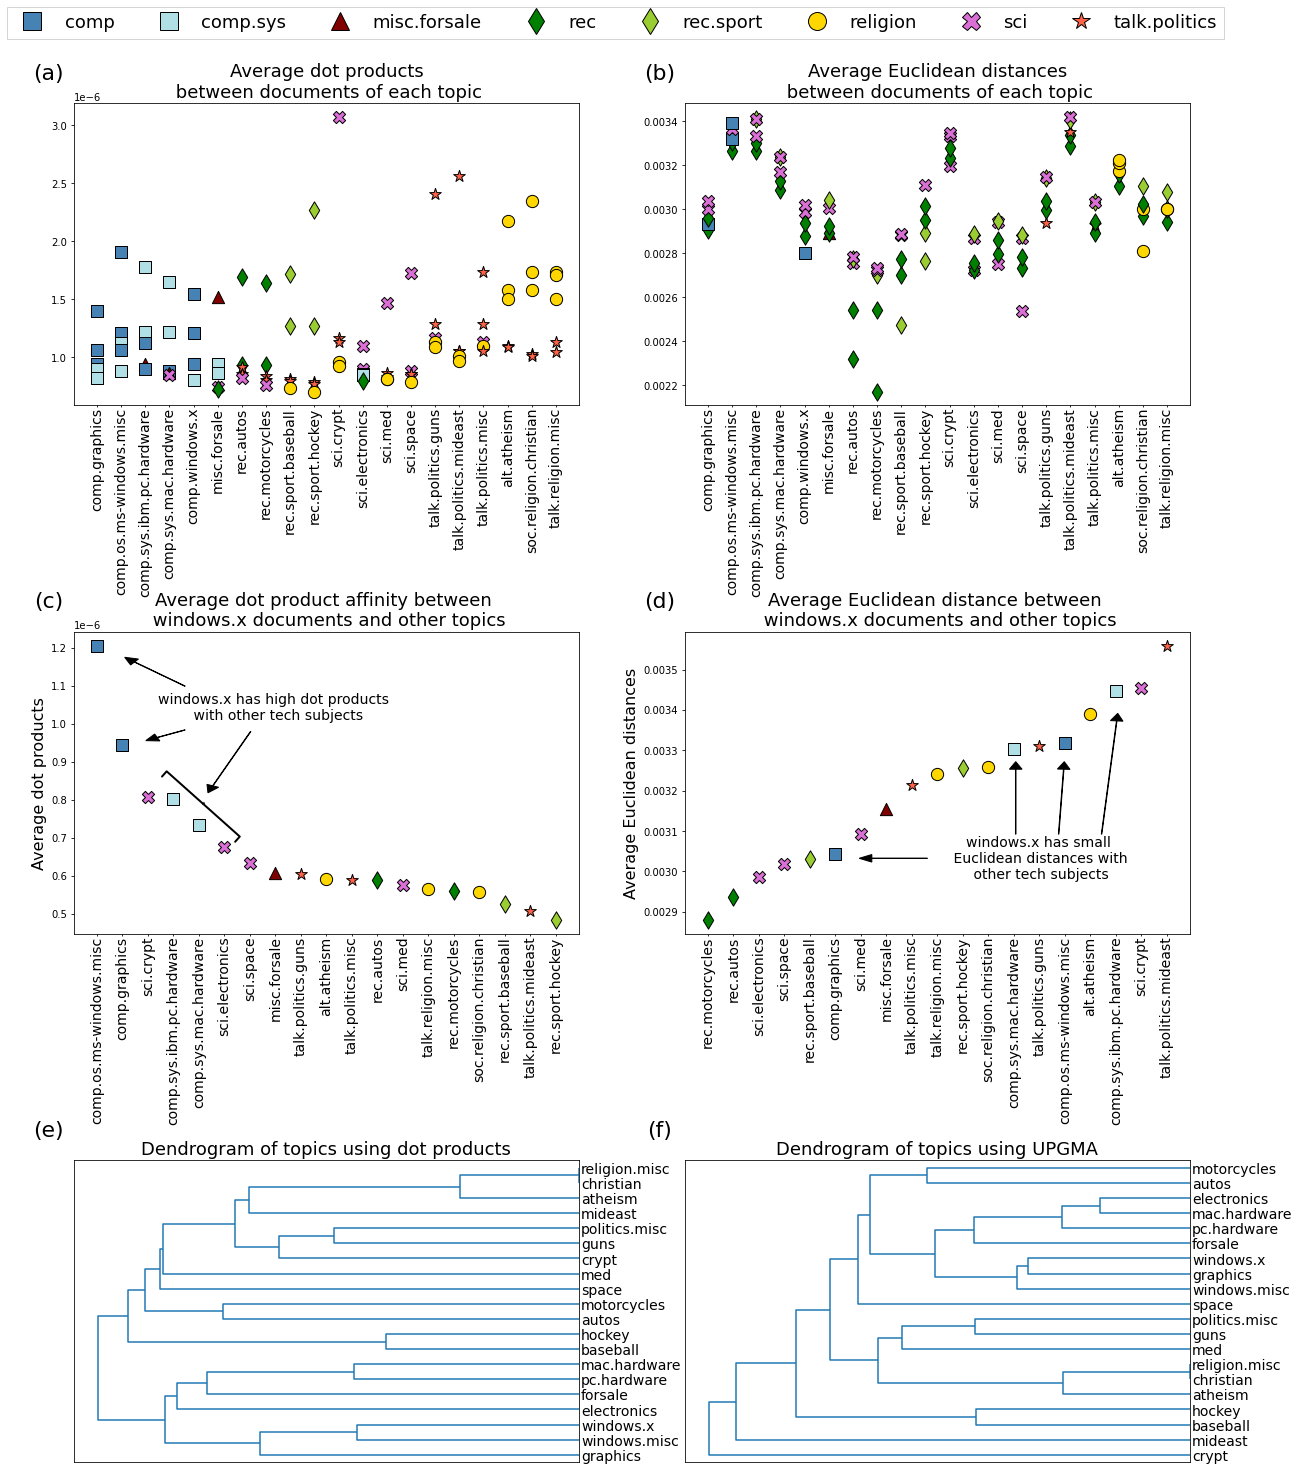

In [46]:
fig,ax = plt.subplots(3,2,figsize = (20,25))

dp_docs = (0,0)
ed_docs = (0,1)
dp_den = (2,0)
ed_den = (2,1)
dp_wind = (1,0)
ed_wind = (1,1)

tick_size = 2
label_size = 14


ax[0,0].text(-.05, 1.1, '(a)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[0,0].transAxes, fontsize = 22)
ax[0,1].text(-.05, 1.1, '(b)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[0,1].transAxes, fontsize = 22)

ax[1,0].text(-.05, 1.1, '(c)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[1,0].transAxes, fontsize = 22)
ax[1,1].text(-.05, 1.1, '(d)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[1,1].transAxes, fontsize = 22)


ax[2,0].text(-.05, 1.1, '(e)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[2,0].transAxes, fontsize = 22)
ax[2,1].text(-.05, 1.1, '(f)', horizontalalignment='center', 
             verticalalignment='center', transform=ax[2,1].transAxes, fontsize = 22)



for c1 in ordered_cats:
    rdf1 = reduce_ip_df[reduce_ip_df['Target1'] == c1]
    for c2 in list(rdf1['Target2']):
        rdf2 = rdf1[rdf1['Target2'] == c2]
        ax[dp_docs].scatter(rdf2['Target1'],rdf2['Mean'],c = target_colour[c2],
           marker = marker_dict[c2],s= 150,edgecolor='black', linewidth=1)
ax[dp_docs].set_title('Average dot products\n between documents of each topic',fontsize = 18)
ax[dp_docs].tick_params(axis='x', labelrotation = 90,size = tick_size, labelsize=label_size,pad=0)

for c1 in ordered_cats:
    rdf1 = reduce_ed_df[reduce_ed_df['Target1'] == c1]
    for c2 in list(rdf1['Target2']):
        rdf2 = rdf1[rdf1['Target2'] == c2]
        ax[ed_docs].scatter(rdf2['Target1'],rdf2['Mean'],c = target_colour[c2],
           marker = marker_dict[c2],s= 150,edgecolor='black', linewidth=1)
ax[ed_docs].set_title('Average Euclidean distances\n between documents of each topic',fontsize = 18)
ax[ed_docs].tick_params(axis='x', labelrotation = 90,size = tick_size, labelsize=label_size,pad=0)

dn1 = dendrogram(ip_t_clust_Z, ax=ax[dp_den],color_threshold = 0,orientation='left',labels = den_labels)
dn2 = dendrogram(a_t_clust_Z, ax=ax[ed_den],color_threshold = 0,labels = den_labels,
                           orientation='left')

ax[dp_den].get_xaxis().set_visible(False)
ax[ed_den].get_xaxis().set_visible(False)
ax[dp_den].tick_params(axis='y', labelrotation = 0,size = tick_size, labelsize=label_size,pad=0)
ax[ed_den].tick_params(axis='y', labelrotation = 0,size = tick_size, labelsize=label_size,pad=0)


ax[dp_den].set_title('Dendrogram of topics using dot products',fontsize = 18)
ax[ed_den].set_title('Dendrogram of topics using UPGMA',fontsize = 18)

for c in list(ip_topic_df['Target2']):
        ax[dp_wind].scatter(ip_topic_df[ip_topic_df['Target2'] == c]['Target2'],ip_topic_df[ip_topic_df['Target2'] == c]['Mean'],c = target_colour[c],
           marker = marker_dict[c],s= 150,edgecolor='black', linewidth=1)
ax[dp_wind].tick_params(axis='x', labelrotation = 90,size = tick_size)
ax[dp_wind].tick_params(axis='x', labelsize=label_size,pad=0)
ax[dp_wind].set_ylabel('Average dot products',size = 16)

ax[dp_wind].text(0.4, 0.75, 'windows.x has high dot products \n with other tech subjects', horizontalalignment='center', 
             verticalalignment='center', transform=ax[dp_wind].transAxes, fontsize = 14)
ax[dp_wind].arrow(x=0.22,y=0.82,dx=-0.1,dy=0.08, head_width=0.025, head_length=0.025,fc='black', ec='black' ,transform=ax[dp_wind].transAxes) # ,fc='k', ec='k'
ax[dp_wind].arrow(x=0.22,y=0.675,dx=-0.055,dy=-0.025, head_width=0.025, head_length=0.025,fc='black', ec='black' , transform=ax[dp_wind].transAxes)
ax[dp_wind].arrow(x=0.35,y=0.67,dx=-0.075,dy=-0.18, head_width=0.025, head_length=0.025,fc='black', ec='black' , transform=ax[dp_wind].transAxes)
## i think xy and xytext are the bottom and top of - which affects roation of bracket? 
ax[dp_wind].annotate('', xy=(0.256, 0.43), xytext=(0.26, .4375),xycoords='axes fraction', 
            fontsize=14, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.5', lw=2.), transform=ax[dp_wind].transAxes)


for c in list(ed_topic_df['Target2']):
        ax[ed_wind].scatter(ed_topic_df[ed_topic_df['Target2'] == c]['Target2'],ed_topic_df[ed_topic_df['Target2'] == c]['Mean'],c = target_colour[c],
           marker = marker_dict[c],s= 150,edgecolor='black', linewidth=1)
ax[ed_wind].tick_params(axis='x', labelrotation = 90,size = tick_size)
ax[ed_wind].tick_params(axis='x', labelsize=label_size,pad=0)
ax[ed_wind].set_ylabel('Average Euclidean distances',size = 16)

ax[ed_wind].text(0.7, 0.25, 'windows.x has small\n Euclidean distances with\n other tech subjects', horizontalalignment='center', 
             verticalalignment='center', transform=ax[ed_wind].transAxes, fontsize = 14)
ax[ed_wind].arrow(x=0.48,y=0.25,dx=-0.11,dy=0, head_width=0.025, head_length=0.025,fc='black', ec='black' ,transform=ax[ed_wind].transAxes) # ,fc='k', ec='k'
ax[ed_wind].arrow(x=0.825,y=0.33,dx=0.03,dy=+0.375, head_width=0.025, head_length=0.025,fc='black', ec='black' , transform=ax[ed_wind].transAxes)
ax[ed_wind].arrow(x=0.655,y=0.33,dx=0.0,dy=+0.215, head_width=0.025, head_length=0.025,fc='black', ec='black' , transform=ax[ed_wind].transAxes)
ax[ed_wind].arrow(x=0.74,y=0.33,dx=0.01,dy=+0.215, head_width=0.025, head_length=0.025,fc='black', ec='black' , transform=ax[ed_wind].transAxes)
# ax[1,0].set_yticks(text_locs,text_ls)

ax[dp_wind].set_title('Average dot product affinity between \n windows.x documents and other topics',fontsize = 18)
ax[ed_wind].set_title('Average Euclidean distance between \n windows.x documents and other topics',fontsize = 18)



plt.subplots_adjust(wspace=.21, hspace=.75)
ax[0,0].legend(handles=legend_elements,loc='upper left',bbox_to_anchor=(-.15,1.35),fontsize=18,
          fancybox=False, shadow=False, ncol=8);

# fig.savefig(f"newsgroup_fig.pdf", bbox_inches='tight')